In [ ]:
! pip install lifelines
import lifelines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from lifelines import CoxPHFitter

In [ ]:
sepsis_all_df = pd.read_csv("/content/data_all.csv")
sepsis_all_df.info()
sepsis_all_df.describe().to_csv("/content/data_summary.csv")
try :
  sepsis_all_df.drop('time_to_death',  axis=1, inplace=True)
except :
  pass
sepsis_all_df.insert(57, column="time_to_death",value=None)
sepsis_all_df_copy = sepsis_all_df.copy(deep=True)
format = '%Y-%m-%d %H:%M:%S'
for i in range(sepsis_all_df.shape[0]):
  if sepsis_all_df["death_flag"][i] == 1 and type(sepsis_all_df["death_time"][i]) is str:
    time_diff = datetime.strptime(sepsis_all_df["death_time"][i],format) - datetime.strptime(sepsis_all_df["sofa_time"][i],format)
    time_diff_in_days = time_diff.total_seconds()/(360*24)
    sepsis_all_df_copy["time_to_death"][i] = time_diff_in_days
    # print(row["time_to_death"])
  else:
    time_diff = datetime.strptime(sepsis_all_df["dischtime"][i],format) - datetime.strptime(sepsis_all_df["sofa_time"][i],format)
    time_diff_in_days = time_diff.total_seconds()/(360*24)
    sepsis_all_df_copy["time_to_death"][i] = time_diff_in_days
    # print(row["time_to_death"])
  if sepsis_all_df["gender"][i] == 'M':
    sepsis_all_df_copy["gender"][i] = 0
  else:
    sepsis_all_df_copy["gender"][i] = 1
sepsis_all_df_non_neg = sepsis_all_df_copy[sepsis_all_df_copy["time_to_death"]>0]
sepsis_all_df_non_neg.info()
dropColList = ["rn_charttime",
              "rn_sofa_stay",
              "sofa_time", 
              "charttime", 
              "antibiotic_time", 
              "culture_time",
              "suspected_infection_time",
              "death_time",
              "subject_id",
              "stay_id",
              "admittime",
              "dischtime",
              "Unnamed: 0",
              "Unnamed: 0.1",
              "subject_id_1",
              "stay_id_1",
              "hadm_id",
              "sepsis3",
              "respiration",
              "coagulation",
              "cardiovascular",
              "renal",
              "cns",
              "liver",
              "mbp",
              "ICULOS",
              "los_hospital"]

for entry in dropColList:
  sepsis_all_df_non_neg = sepsis_all_df_non_neg.drop(entry, axis=1)

sepsis_all_df_non_neg.info()

In [ ]:
sepsis_Y = sepsis_all_df_non_neg["time_to_death"]
sepsis_X = sepsis_all_df_non_neg.drop("time_to_death", axis=1)
sepsis_X.isna().sum()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( sepsis_X, sepsis_Y, test_size=0.20, random_state=42)
trainData = [X_train, y_train]
trainData = pd.concat(trainData, axis = 1)
trainData.to_csv("/content/sepsisTrainData_19May.csv")
testData = [X_test, y_test]
testData = pd.concat(testData, axis =1)
testData.to_csv("/content/sepsisTestData_19May.csv")

In [ ]:
trainData.shape

In [ ]:
testData.shape

In [ ]:
testData.info()

In [ ]:
trainData.info()

In [ ]:
trainData.corr()

In [ ]:
cph = CoxPHFitter(l1_ratio=0.5)
cph.fit(trainData, duration_col='time_to_death', event_col='death_flag',show_progress=True, step_size=0.1)
cph.print_summary()

In [ ]:
cph.log_likelihood_

In [ ]:
cph.variance_matrix_

In [ ]:
cph.plot()

In [ ]:
cph.params_

In [ ]:
cph.baseline_hazard_

In [ ]:
cph.log_likelihood_ratio_test()

In [ ]:
patient_data = pd.read_csv("/content/pat4.csv")
try_df_copy = patient_data.copy(deep=True)
for i in range(patient_data.shape[0]):
  if patient_data["gender"][i] == 'M':
    try_df_copy["gender"][i] = 0
  else:
    try_df_copy["gender"][i] = 1

In [68]:
survival_df = cph.predict_survival_function(try_df_copy)
survival_df.to_csv("pat4_survival.csv")

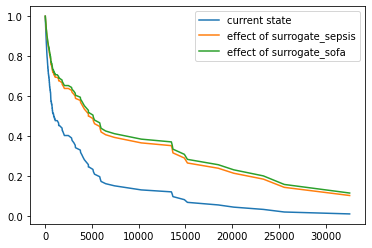

In [72]:
updated_survival_df = pd.read_csv("/content/part2_survival_updated.csv")
x = []
y_conf = []
y_surr_sepsis = []
y_surr_sofa = []
for _, entry in updated_survival_df.iterrows():
  x.append(entry["day"])
  y_conf.append(entry["confounder"])
  y_surr_sepsis.append(entry["surrogate_sepsis"])
  y_surr_sofa.append(entry["surrogate_sofa"])


plt.plot(x, y_conf, label = "current state")
plt.plot(x, y_surr_sepsis, label = "effect of surrogate_sepsis")
plt.plot(x, y_surr_sofa, label = "effect of surrogate_sofa")
plt.legend()
plt.show()